In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Angles (3) + Accel (3) + Compass(3)
#TODO 2 imus in so double data width?
#data_input_width = 3 + 3 + 3
data_input_width = 3 #use only angles for now
time_steps= 10

# Input Format
# [angles(t-time_steps+1), accel(t-time_steps+1), compass(t-time_steps+1)]
# ...
# [angles(t-2), accel(t-2), compass(t-2)]
# [angles(t-1), accel(t-1), compass(t-1)]
# [angles(t) accel(t), compass(t)]

#output Format
#
# [correct_exercise, overcompensation]
#

In [4]:
model = keras.Sequential()
#TODO I don't know if simpleRNN should come before or after LSTM
#TODO another input second IMU?
model.add(layers.SimpleRNN(32, input_shape = (time_steps, data_input_width), return_sequences=True))
model.add(layers.LSTM(16))
model.add(layers.Dense(10))
model.add(layers.Dense(2, activation='sigmoid')) #sigmoid has output between 0 and 1 (confidence)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 32)            1152      
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 4,480
Trainable params: 4,480
Non-trainable params: 0
_________________________________________________________________


In [18]:
def convertToMatrix(data, step):
    X = []
    for i in range(len(data) - step):
        d = i+step
        X.append(data[i:d,])
    return np.array(X)

def read_format_csv(filename):
    ignore_cols = ("time","IMU#","accelx","accely","accelz","compassx","compassy","compassz")
    data = pd.read_csv(filename)

    for col in ignore_cols:
        data.pop(col)

    return np.array(data)

def get_in(filename):
    inputs = convertToMatrix(read_format_csv(filename), time_steps)
    return inputs

def get_expect(inputs):
    outputs = np.zeros((len(inputs), 2))
    for i in range(len(outputs)):
        outputs[i] = (i / len(inputs))
    return outputs

#inputs = get_in("./data_simple./imu0_10_27_0.csv")
#outputs = get_expect(inputs)
#print(inputs)
#print(outputs)


In [59]:
def training_generator():
    for i in (0, 1):
        temp_in = get_in("./data_simple/imu0_10_27_" + str(i) + ".csv")
        temp_out = get_expect(temp_in)
        yield (temp_in, temp_out)


In [62]:

history = model.fit(x=training_generator())



2/2 [==============================] - 0s 36ms/step - loss: 0.1129


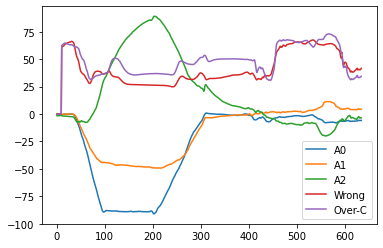

In [6]:
file_name = "./data_simple/original/imu1_10_27.csv"

input_data = read_format_csv(file_name)

angle0 = input_data.flatten()[::3]
angle1 = input_data.flatten()[1::3]
angle2 = input_data.flatten()[2::3]

data_in = get_in(file_name) 
prediction = model.predict(data_in)
x_points = np.arange(0,len(angle0))

prediction_wrong = prediction.flatten()[::2]
prediction_comp = prediction.flatten()[1::2]

for i in range(time_steps):
    prediction_wrong = np.insert(prediction_wrong, 0, 0)
    prediction_comp = np.insert(prediction_comp, 0, 0)

prediction_wrong *= 100
prediction_comp *= 100

plt.plot(x_points, angle0, label="A0")
plt.plot(x_points, angle1, label="A1")
plt.plot(x_points, angle2, label="A2")
plt.plot(x_points, prediction_wrong, label="Wrong")
plt.plot(x_points, prediction_comp, label="Over-C")
plt.legend()
plt.show()

